# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

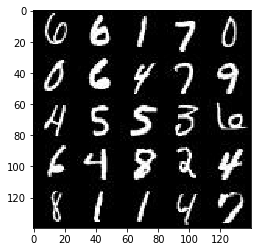

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

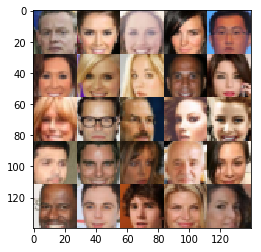

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')

    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer =  28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 2*2*512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5,strides=2, padding='same')
        
        out = tf.tanh(logits)
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 50
    print_every = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for each_batch in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: each_batch, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: each_batch, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: each_batch})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1504... Generator Loss: 2.4178
Epoch 1/2... Discriminator Loss: 0.0994... Generator Loss: 2.8737
Epoch 1/2... Discriminator Loss: 0.2176... Generator Loss: 14.9624
Epoch 1/2... Discriminator Loss: 3.7358... Generator Loss: 13.8414


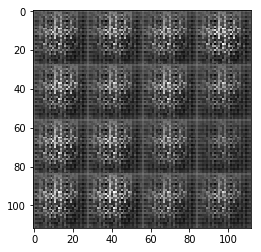

Epoch 1/2... Discriminator Loss: 0.2601... Generator Loss: 1.8454
Epoch 1/2... Discriminator Loss: 0.5048... Generator Loss: 1.7870
Epoch 1/2... Discriminator Loss: 0.4303... Generator Loss: 2.3808
Epoch 1/2... Discriminator Loss: 1.2628... Generator Loss: 5.7335
Epoch 1/2... Discriminator Loss: 0.0282... Generator Loss: 6.8965


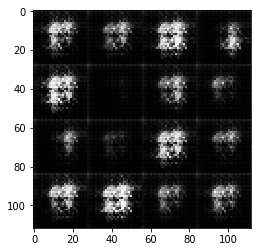

Epoch 1/2... Discriminator Loss: 0.1618... Generator Loss: 3.0494
Epoch 1/2... Discriminator Loss: 0.1664... Generator Loss: 2.6603
Epoch 1/2... Discriminator Loss: 0.4689... Generator Loss: 6.3833
Epoch 1/2... Discriminator Loss: 0.1576... Generator Loss: 4.3556
Epoch 1/2... Discriminator Loss: 0.0653... Generator Loss: 3.5436


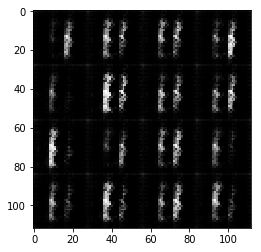

Epoch 1/2... Discriminator Loss: 0.0536... Generator Loss: 6.4208
Epoch 1/2... Discriminator Loss: 0.1703... Generator Loss: 2.2728
Epoch 1/2... Discriminator Loss: 0.2463... Generator Loss: 19.9118
Epoch 1/2... Discriminator Loss: 0.8728... Generator Loss: 0.8456
Epoch 1/2... Discriminator Loss: 0.1011... Generator Loss: 3.2727


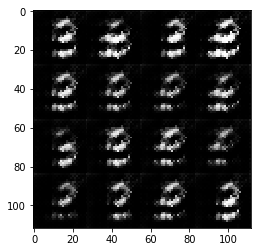

Epoch 1/2... Discriminator Loss: 0.0847... Generator Loss: 3.1568
Epoch 1/2... Discriminator Loss: 0.0469... Generator Loss: 4.3825
Epoch 1/2... Discriminator Loss: 0.0520... Generator Loss: 3.4779
Epoch 1/2... Discriminator Loss: 0.0271... Generator Loss: 4.2740
Epoch 1/2... Discriminator Loss: 0.0209... Generator Loss: 4.7517


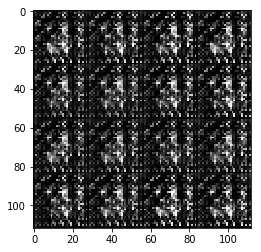

Epoch 1/2... Discriminator Loss: 0.0243... Generator Loss: 4.3251
Epoch 1/2... Discriminator Loss: 0.0471... Generator Loss: 3.5406
Epoch 1/2... Discriminator Loss: 0.0391... Generator Loss: 5.9698
Epoch 1/2... Discriminator Loss: 0.3154... Generator Loss: 1.6167
Epoch 1/2... Discriminator Loss: 0.2068... Generator Loss: 3.3440


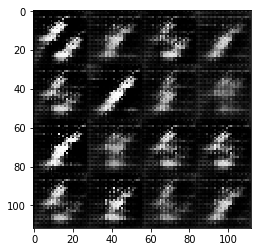

Epoch 1/2... Discriminator Loss: 0.8246... Generator Loss: 14.0718
Epoch 1/2... Discriminator Loss: 0.1971... Generator Loss: 3.1780
Epoch 1/2... Discriminator Loss: 0.0747... Generator Loss: 3.1423
Epoch 1/2... Discriminator Loss: 0.1249... Generator Loss: 2.8000
Epoch 1/2... Discriminator Loss: 0.5547... Generator Loss: 4.7323


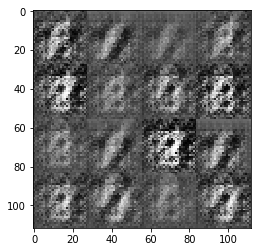

Epoch 1/2... Discriminator Loss: 1.1852... Generator Loss: 0.6876
Epoch 1/2... Discriminator Loss: 0.3098... Generator Loss: 4.9591
Epoch 1/2... Discriminator Loss: 0.2143... Generator Loss: 2.6044
Epoch 1/2... Discriminator Loss: 0.1858... Generator Loss: 2.9484
Epoch 1/2... Discriminator Loss: 0.2621... Generator Loss: 4.3707


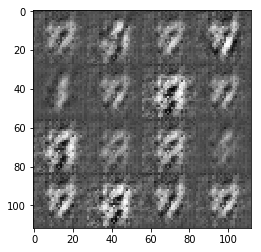

Epoch 1/2... Discriminator Loss: 0.2184... Generator Loss: 3.3048
Epoch 1/2... Discriminator Loss: 1.1274... Generator Loss: 0.5404
Epoch 1/2... Discriminator Loss: 0.3531... Generator Loss: 2.9760
Epoch 1/2... Discriminator Loss: 0.3803... Generator Loss: 1.5111
Epoch 1/2... Discriminator Loss: 0.4490... Generator Loss: 6.1861


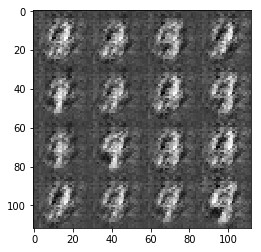

Epoch 1/2... Discriminator Loss: 0.1101... Generator Loss: 4.1956
Epoch 1/2... Discriminator Loss: 0.0466... Generator Loss: 3.6825
Epoch 1/2... Discriminator Loss: 0.2896... Generator Loss: 2.6531
Epoch 1/2... Discriminator Loss: 0.1775... Generator Loss: 4.0506
Epoch 1/2... Discriminator Loss: 0.1338... Generator Loss: 2.7949


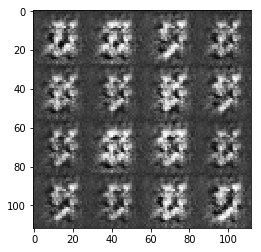

Epoch 1/2... Discriminator Loss: 0.1217... Generator Loss: 2.7837
Epoch 1/2... Discriminator Loss: 0.2637... Generator Loss: 1.7977
Epoch 1/2... Discriminator Loss: 0.6929... Generator Loss: 0.8733
Epoch 1/2... Discriminator Loss: 0.1441... Generator Loss: 3.6600
Epoch 1/2... Discriminator Loss: 0.2335... Generator Loss: 4.1808


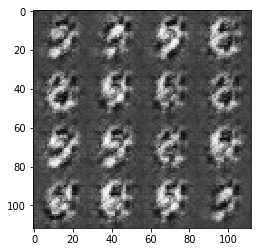

Epoch 1/2... Discriminator Loss: 0.1430... Generator Loss: 3.4490
Epoch 1/2... Discriminator Loss: 0.1395... Generator Loss: 2.6586
Epoch 1/2... Discriminator Loss: 0.1157... Generator Loss: 2.9502
Epoch 1/2... Discriminator Loss: 0.1596... Generator Loss: 6.1687
Epoch 1/2... Discriminator Loss: 0.3845... Generator Loss: 1.5953


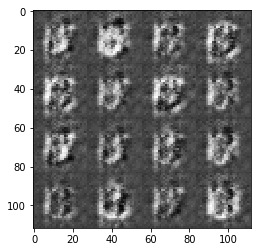

Epoch 1/2... Discriminator Loss: 0.1256... Generator Loss: 2.6919
Epoch 1/2... Discriminator Loss: 0.2259... Generator Loss: 2.1743
Epoch 1/2... Discriminator Loss: 0.0881... Generator Loss: 3.2869
Epoch 1/2... Discriminator Loss: 0.1543... Generator Loss: 3.0197
Epoch 1/2... Discriminator Loss: 0.0534... Generator Loss: 3.8546


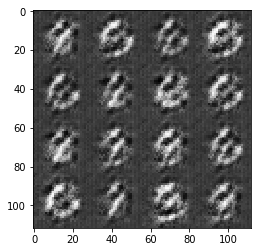

Epoch 1/2... Discriminator Loss: 0.1858... Generator Loss: 2.0481
Epoch 1/2... Discriminator Loss: 0.5190... Generator Loss: 8.1335
Epoch 1/2... Discriminator Loss: 0.5162... Generator Loss: 1.3458
Epoch 1/2... Discriminator Loss: 0.3055... Generator Loss: 2.2859
Epoch 1/2... Discriminator Loss: 0.1049... Generator Loss: 3.2865


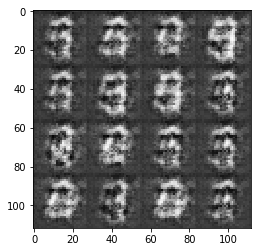

Epoch 1/2... Discriminator Loss: 0.1326... Generator Loss: 2.6449
Epoch 1/2... Discriminator Loss: 0.1011... Generator Loss: 3.0830
Epoch 1/2... Discriminator Loss: 0.5897... Generator Loss: 1.1216
Epoch 1/2... Discriminator Loss: 0.1066... Generator Loss: 3.4914
Epoch 1/2... Discriminator Loss: 0.0645... Generator Loss: 4.4866


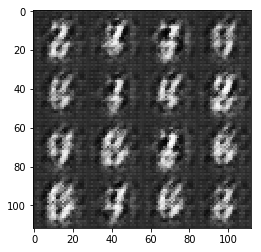

Epoch 1/2... Discriminator Loss: 0.3601... Generator Loss: 1.8381
Epoch 1/2... Discriminator Loss: 0.1089... Generator Loss: 3.4617
Epoch 1/2... Discriminator Loss: 0.1194... Generator Loss: 3.1983
Epoch 1/2... Discriminator Loss: 0.1167... Generator Loss: 2.8327
Epoch 1/2... Discriminator Loss: 0.1401... Generator Loss: 2.4878


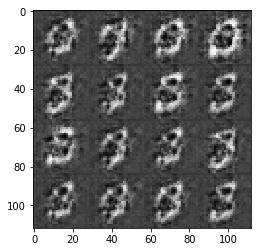

Epoch 1/2... Discriminator Loss: 0.0311... Generator Loss: 5.4968
Epoch 1/2... Discriminator Loss: 0.0783... Generator Loss: 3.9959
Epoch 1/2... Discriminator Loss: 0.0651... Generator Loss: 5.6362
Epoch 1/2... Discriminator Loss: 0.3091... Generator Loss: 4.5017
Epoch 1/2... Discriminator Loss: 1.0227... Generator Loss: 0.7347


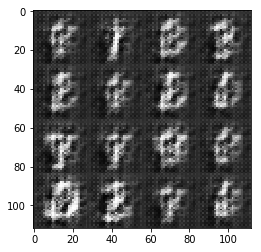

Epoch 1/2... Discriminator Loss: 0.2822... Generator Loss: 6.0615
Epoch 1/2... Discriminator Loss: 0.1046... Generator Loss: 2.9760
Epoch 1/2... Discriminator Loss: 0.2004... Generator Loss: 2.1197
Epoch 1/2... Discriminator Loss: 0.1874... Generator Loss: 2.3561
Epoch 1/2... Discriminator Loss: 0.0905... Generator Loss: 3.4018


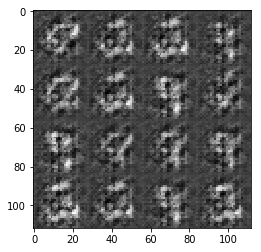

Epoch 1/2... Discriminator Loss: 0.0575... Generator Loss: 4.2358
Epoch 1/2... Discriminator Loss: 0.1002... Generator Loss: 3.0429
Epoch 1/2... Discriminator Loss: 0.0613... Generator Loss: 4.2071
Epoch 1/2... Discriminator Loss: 0.1110... Generator Loss: 4.5178
Epoch 2/2... Discriminator Loss: 0.0589... Generator Loss: 4.6404


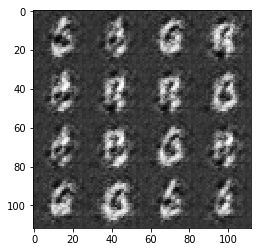

Epoch 2/2... Discriminator Loss: 0.1257... Generator Loss: 2.6229
Epoch 2/2... Discriminator Loss: 0.0366... Generator Loss: 4.3844
Epoch 2/2... Discriminator Loss: 0.1788... Generator Loss: 2.3513
Epoch 2/2... Discriminator Loss: 0.1312... Generator Loss: 2.9797
Epoch 2/2... Discriminator Loss: 0.0858... Generator Loss: 4.5201


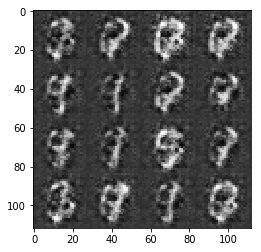

Epoch 2/2... Discriminator Loss: 0.0321... Generator Loss: 6.6745
Epoch 2/2... Discriminator Loss: 0.0753... Generator Loss: 3.0793
Epoch 2/2... Discriminator Loss: 0.0409... Generator Loss: 3.8388
Epoch 2/2... Discriminator Loss: 0.0493... Generator Loss: 4.7761
Epoch 2/2... Discriminator Loss: 0.0612... Generator Loss: 7.8749


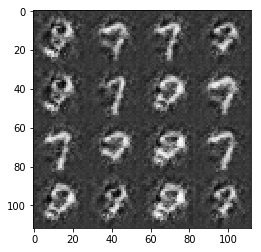

Epoch 2/2... Discriminator Loss: 0.2204... Generator Loss: 1.7951
Epoch 2/2... Discriminator Loss: 0.0637... Generator Loss: 3.3236
Epoch 2/2... Discriminator Loss: 0.0378... Generator Loss: 4.4780
Epoch 2/2... Discriminator Loss: 0.0409... Generator Loss: 4.0898
Epoch 2/2... Discriminator Loss: 0.0290... Generator Loss: 4.3685


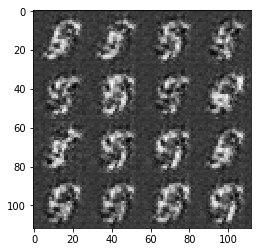

Epoch 2/2... Discriminator Loss: 0.0232... Generator Loss: 4.9316
Epoch 2/2... Discriminator Loss: 0.0470... Generator Loss: 3.6744
Epoch 2/2... Discriminator Loss: 0.0115... Generator Loss: 6.4724
Epoch 2/2... Discriminator Loss: 0.0444... Generator Loss: 3.8167
Epoch 2/2... Discriminator Loss: 0.0422... Generator Loss: 3.7781


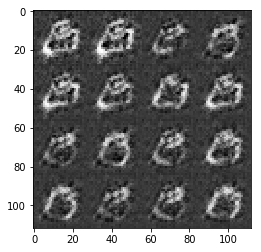

Epoch 2/2... Discriminator Loss: 0.0223... Generator Loss: 5.1376
Epoch 2/2... Discriminator Loss: 0.0171... Generator Loss: 7.0692
Epoch 2/2... Discriminator Loss: 0.0111... Generator Loss: 5.9107
Epoch 2/2... Discriminator Loss: 0.0211... Generator Loss: 4.6679
Epoch 2/2... Discriminator Loss: 0.0396... Generator Loss: 4.1557


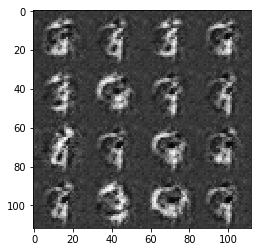

Epoch 2/2... Discriminator Loss: 0.0499... Generator Loss: 3.3029
Epoch 2/2... Discriminator Loss: 0.0091... Generator Loss: 6.3285
Epoch 2/2... Discriminator Loss: 7.4258... Generator Loss: 0.0009
Epoch 2/2... Discriminator Loss: 0.5119... Generator Loss: 2.2018
Epoch 2/2... Discriminator Loss: 0.2072... Generator Loss: 2.2738


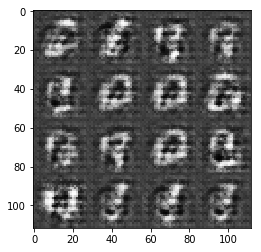

Epoch 2/2... Discriminator Loss: 0.7710... Generator Loss: 1.0138
Epoch 2/2... Discriminator Loss: 0.2481... Generator Loss: 2.2518
Epoch 2/2... Discriminator Loss: 0.2832... Generator Loss: 7.7593
Epoch 2/2... Discriminator Loss: 0.6573... Generator Loss: 0.9465
Epoch 2/2... Discriminator Loss: 0.1282... Generator Loss: 2.8467


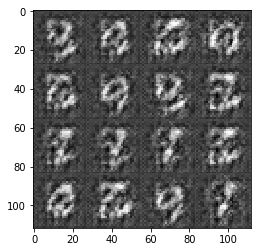

Epoch 2/2... Discriminator Loss: 0.0955... Generator Loss: 3.7558
Epoch 2/2... Discriminator Loss: 0.0838... Generator Loss: 3.3725
Epoch 2/2... Discriminator Loss: 0.4139... Generator Loss: 1.4572
Epoch 2/2... Discriminator Loss: 0.0223... Generator Loss: 4.7279
Epoch 2/2... Discriminator Loss: 0.1641... Generator Loss: 2.1986


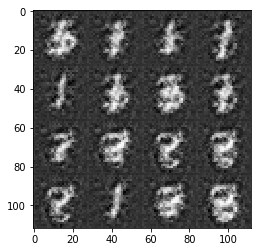

Epoch 2/2... Discriminator Loss: 0.1466... Generator Loss: 2.5501
Epoch 2/2... Discriminator Loss: 0.0170... Generator Loss: 5.4809
Epoch 2/2... Discriminator Loss: 0.1527... Generator Loss: 2.2282
Epoch 2/2... Discriminator Loss: 0.1348... Generator Loss: 4.5938
Epoch 2/2... Discriminator Loss: 0.2018... Generator Loss: 2.6822


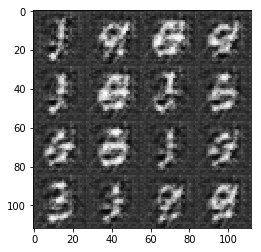

Epoch 2/2... Discriminator Loss: 0.1324... Generator Loss: 2.8458
Epoch 2/2... Discriminator Loss: 0.0565... Generator Loss: 4.4440
Epoch 2/2... Discriminator Loss: 0.0852... Generator Loss: 3.0916
Epoch 2/2... Discriminator Loss: 0.0639... Generator Loss: 4.0335
Epoch 2/2... Discriminator Loss: 0.0521... Generator Loss: 3.8321


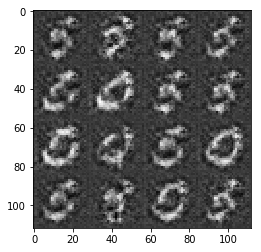

Epoch 2/2... Discriminator Loss: 0.0419... Generator Loss: 4.8028
Epoch 2/2... Discriminator Loss: 0.0482... Generator Loss: 3.4482
Epoch 2/2... Discriminator Loss: 0.0961... Generator Loss: 2.7198
Epoch 2/2... Discriminator Loss: 0.0241... Generator Loss: 5.5912
Epoch 2/2... Discriminator Loss: 0.2177... Generator Loss: 3.9647


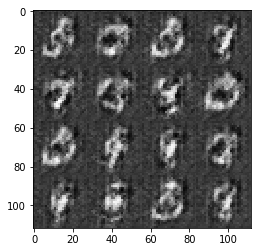

Epoch 2/2... Discriminator Loss: 0.2162... Generator Loss: 2.3351
Epoch 2/2... Discriminator Loss: 0.1833... Generator Loss: 2.5592
Epoch 2/2... Discriminator Loss: 0.1321... Generator Loss: 3.0463
Epoch 2/2... Discriminator Loss: 0.1861... Generator Loss: 2.3351
Epoch 2/2... Discriminator Loss: 0.0725... Generator Loss: 3.3372


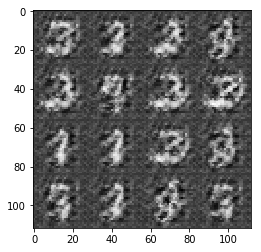

Epoch 2/2... Discriminator Loss: 0.0983... Generator Loss: 3.0556
Epoch 2/2... Discriminator Loss: 0.0887... Generator Loss: 3.6976
Epoch 2/2... Discriminator Loss: 0.1479... Generator Loss: 2.1854
Epoch 2/2... Discriminator Loss: 0.0495... Generator Loss: 4.7535
Epoch 2/2... Discriminator Loss: 0.0824... Generator Loss: 2.9349


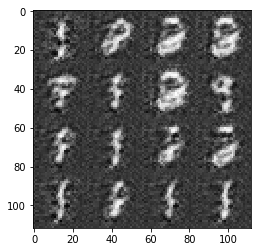

Epoch 2/2... Discriminator Loss: 0.0605... Generator Loss: 4.2302
Epoch 2/2... Discriminator Loss: 0.1870... Generator Loss: 2.0894
Epoch 2/2... Discriminator Loss: 0.1526... Generator Loss: 3.4521
Epoch 2/2... Discriminator Loss: 0.0719... Generator Loss: 4.9121
Epoch 2/2... Discriminator Loss: 0.0920... Generator Loss: 3.2166


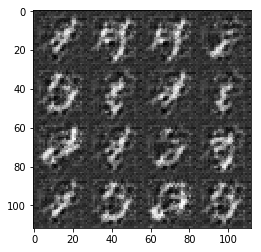

Epoch 2/2... Discriminator Loss: 0.1080... Generator Loss: 2.8290
Epoch 2/2... Discriminator Loss: 0.0691... Generator Loss: 3.7938
Epoch 2/2... Discriminator Loss: 0.1047... Generator Loss: 2.7528
Epoch 2/2... Discriminator Loss: 0.0334... Generator Loss: 4.7908
Epoch 2/2... Discriminator Loss: 0.0865... Generator Loss: 2.9271


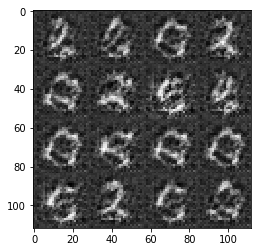

Epoch 2/2... Discriminator Loss: 0.0236... Generator Loss: 4.8271
Epoch 2/2... Discriminator Loss: 0.0253... Generator Loss: 4.6281
Epoch 2/2... Discriminator Loss: 0.0107... Generator Loss: 6.6910
Epoch 2/2... Discriminator Loss: 0.0143... Generator Loss: 5.7848
Epoch 2/2... Discriminator Loss: 0.0234... Generator Loss: 4.4477


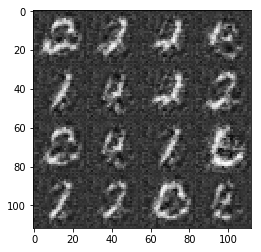

Epoch 2/2... Discriminator Loss: 0.0269... Generator Loss: 4.4539
Epoch 2/2... Discriminator Loss: 0.0682... Generator Loss: 3.0670
Epoch 2/2... Discriminator Loss: 0.0341... Generator Loss: 4.3030
Epoch 2/2... Discriminator Loss: 0.0185... Generator Loss: 4.8256
Epoch 2/2... Discriminator Loss: 0.0113... Generator Loss: 5.2574


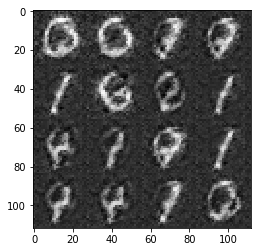

Epoch 2/2... Discriminator Loss: 0.0192... Generator Loss: 6.4091
Epoch 2/2... Discriminator Loss: 0.0182... Generator Loss: 4.7352
Epoch 2/2... Discriminator Loss: 0.0146... Generator Loss: 7.1144
Epoch 2/2... Discriminator Loss: 0.0375... Generator Loss: 3.8914
Epoch 2/2... Discriminator Loss: 0.0251... Generator Loss: 5.6649


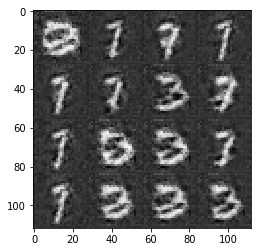

Epoch 2/2... Discriminator Loss: 0.0278... Generator Loss: 4.1393
Epoch 2/2... Discriminator Loss: 0.0201... Generator Loss: 7.7769
Epoch 2/2... Discriminator Loss: 0.0067... Generator Loss: 6.5169


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5661... Generator Loss: 7.0078
Epoch 1/1... Discriminator Loss: 5.1230... Generator Loss: 0.0072
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.3251
Epoch 1/1... Discriminator Loss: 0.5376... Generator Loss: 12.8379


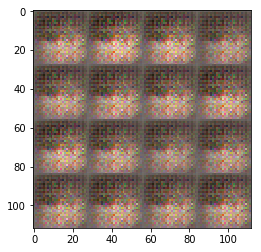

Epoch 1/1... Discriminator Loss: 0.8950... Generator Loss: 10.9030
Epoch 1/1... Discriminator Loss: 0.3437... Generator Loss: 10.3934
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.5322
Epoch 1/1... Discriminator Loss: 0.6820... Generator Loss: 4.4320
Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 10.5810


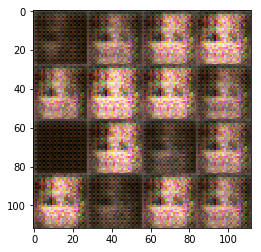

Epoch 1/1... Discriminator Loss: 0.3547... Generator Loss: 1.5153
Epoch 1/1... Discriminator Loss: 0.1825... Generator Loss: 2.7307
Epoch 1/1... Discriminator Loss: 0.1697... Generator Loss: 2.2179
Epoch 1/1... Discriminator Loss: 0.1557... Generator Loss: 4.1554
Epoch 1/1... Discriminator Loss: 0.1547... Generator Loss: 6.2655


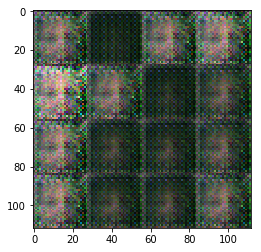

Epoch 1/1... Discriminator Loss: 0.0639... Generator Loss: 3.0087
Epoch 1/1... Discriminator Loss: 0.1777... Generator Loss: 2.1704
Epoch 1/1... Discriminator Loss: 0.0633... Generator Loss: 7.8820
Epoch 1/1... Discriminator Loss: 0.0601... Generator Loss: 4.2401
Epoch 1/1... Discriminator Loss: 0.0660... Generator Loss: 8.5655


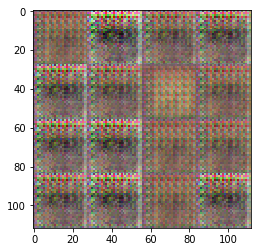

Epoch 1/1... Discriminator Loss: 0.0282... Generator Loss: 4.7974
Epoch 1/1... Discriminator Loss: 1.8345... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 0.1471... Generator Loss: 2.8554
Epoch 1/1... Discriminator Loss: 0.0348... Generator Loss: 6.5843
Epoch 1/1... Discriminator Loss: 0.1515... Generator Loss: 4.7458


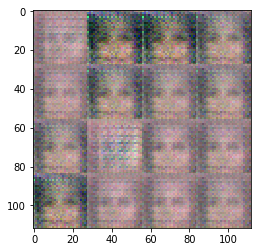

Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 2.5823
Epoch 1/1... Discriminator Loss: 0.3262... Generator Loss: 1.7324
Epoch 1/1... Discriminator Loss: 0.5096... Generator Loss: 3.1087
Epoch 1/1... Discriminator Loss: 0.6441... Generator Loss: 1.7671
Epoch 1/1... Discriminator Loss: 0.6030... Generator Loss: 4.2029


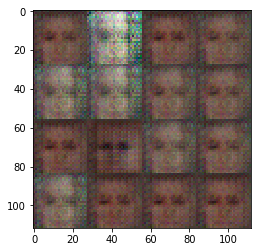

Epoch 1/1... Discriminator Loss: 0.7268... Generator Loss: 3.2773
Epoch 1/1... Discriminator Loss: 0.0610... Generator Loss: 5.0521
Epoch 1/1... Discriminator Loss: 0.6902... Generator Loss: 1.1060
Epoch 1/1... Discriminator Loss: 0.2554... Generator Loss: 3.5080
Epoch 1/1... Discriminator Loss: 0.5149... Generator Loss: 1.0110


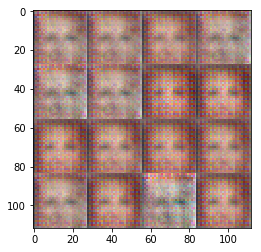

Epoch 1/1... Discriminator Loss: 0.0558... Generator Loss: 4.4350
Epoch 1/1... Discriminator Loss: 0.4322... Generator Loss: 4.0414
Epoch 1/1... Discriminator Loss: 2.1449... Generator Loss: 0.2355
Epoch 1/1... Discriminator Loss: 0.5631... Generator Loss: 3.3830
Epoch 1/1... Discriminator Loss: 1.8874... Generator Loss: 0.3819


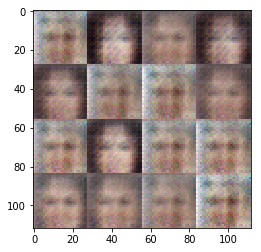

Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 2.6091
Epoch 1/1... Discriminator Loss: 0.5725... Generator Loss: 1.1608
Epoch 1/1... Discriminator Loss: 0.4236... Generator Loss: 1.6604
Epoch 1/1... Discriminator Loss: 0.7504... Generator Loss: 1.6421
Epoch 1/1... Discriminator Loss: 0.3396... Generator Loss: 2.9562


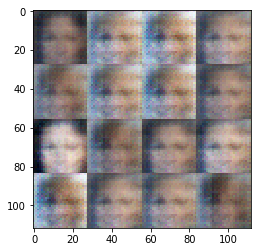

Epoch 1/1... Discriminator Loss: 2.3809... Generator Loss: 8.9056
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 0.6208... Generator Loss: 1.3683
Epoch 1/1... Discriminator Loss: 1.8162... Generator Loss: 0.1981
Epoch 1/1... Discriminator Loss: 2.3819... Generator Loss: 0.1178


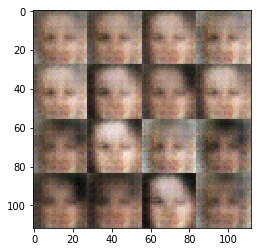

Epoch 1/1... Discriminator Loss: 2.6403... Generator Loss: 4.8136
Epoch 1/1... Discriminator Loss: 0.9157... Generator Loss: 1.7010
Epoch 1/1... Discriminator Loss: 0.3096... Generator Loss: 2.2580
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 6.6559
Epoch 1/1... Discriminator Loss: 0.2884... Generator Loss: 1.6028


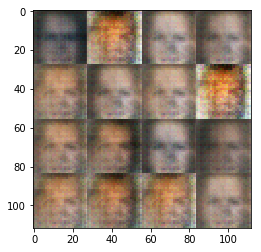

Epoch 1/1... Discriminator Loss: 0.4773... Generator Loss: 1.6602
Epoch 1/1... Discriminator Loss: 0.7123... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 4.8820
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.5375
Epoch 1/1... Discriminator Loss: 0.4388... Generator Loss: 6.8120


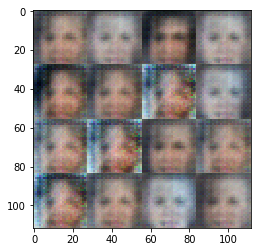

Epoch 1/1... Discriminator Loss: 0.1000... Generator Loss: 4.3983
Epoch 1/1... Discriminator Loss: 0.0944... Generator Loss: 3.1511
Epoch 1/1... Discriminator Loss: 0.1528... Generator Loss: 2.0910
Epoch 1/1... Discriminator Loss: 0.0363... Generator Loss: 5.5349
Epoch 1/1... Discriminator Loss: 0.0126... Generator Loss: 6.4767


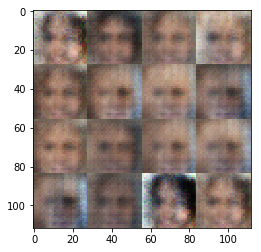

Epoch 1/1... Discriminator Loss: 0.0154... Generator Loss: 6.6092
Epoch 1/1... Discriminator Loss: 1.7625... Generator Loss: 0.4387
Epoch 1/1... Discriminator Loss: 0.8470... Generator Loss: 7.6268
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 0.5259
Epoch 1/1... Discriminator Loss: 0.5840... Generator Loss: 1.2415


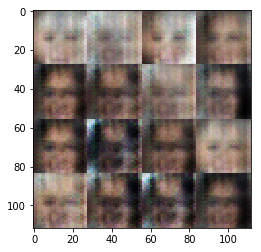

Epoch 1/1... Discriminator Loss: 0.3950... Generator Loss: 2.1762
Epoch 1/1... Discriminator Loss: 0.7264... Generator Loss: 1.4630
Epoch 1/1... Discriminator Loss: 0.1093... Generator Loss: 3.1827
Epoch 1/1... Discriminator Loss: 0.2684... Generator Loss: 2.2959
Epoch 1/1... Discriminator Loss: 0.2023... Generator Loss: 1.9329


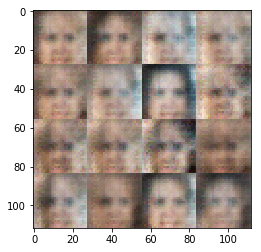

Epoch 1/1... Discriminator Loss: 0.2178... Generator Loss: 1.9754
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.3522
Epoch 1/1... Discriminator Loss: 0.1256... Generator Loss: 3.3291
Epoch 1/1... Discriminator Loss: 0.4477... Generator Loss: 1.9272
Epoch 1/1... Discriminator Loss: 0.3870... Generator Loss: 1.3894


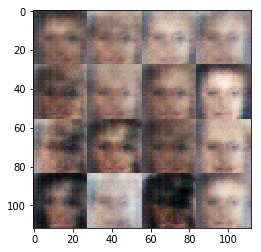

Epoch 1/1... Discriminator Loss: 3.8933... Generator Loss: 4.9286
Epoch 1/1... Discriminator Loss: 0.1827... Generator Loss: 2.8217
Epoch 1/1... Discriminator Loss: 0.6323... Generator Loss: 1.0550
Epoch 1/1... Discriminator Loss: 0.2084... Generator Loss: 3.7205
Epoch 1/1... Discriminator Loss: 0.5365... Generator Loss: 6.6560


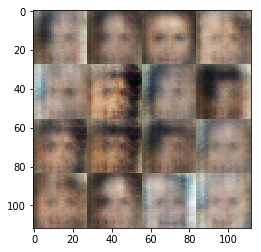

Epoch 1/1... Discriminator Loss: 0.1107... Generator Loss: 3.7478
Epoch 1/1... Discriminator Loss: 0.0687... Generator Loss: 2.9572
Epoch 1/1... Discriminator Loss: 0.0950... Generator Loss: 2.9102
Epoch 1/1... Discriminator Loss: 0.0614... Generator Loss: 4.9595
Epoch 1/1... Discriminator Loss: 0.6345... Generator Loss: 1.0456


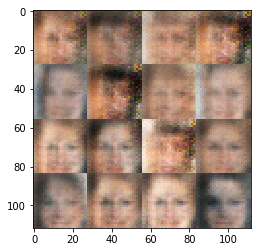

Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 0.1461... Generator Loss: 2.6652
Epoch 1/1... Discriminator Loss: 1.7358... Generator Loss: 7.8722
Epoch 1/1... Discriminator Loss: 0.3282... Generator Loss: 1.6858
Epoch 1/1... Discriminator Loss: 0.1441... Generator Loss: 4.6254


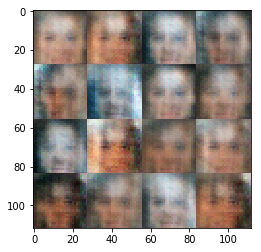

Epoch 1/1... Discriminator Loss: 2.6852... Generator Loss: 7.6178
Epoch 1/1... Discriminator Loss: 0.6543... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 0.0184... Generator Loss: 6.2359
Epoch 1/1... Discriminator Loss: 0.2992... Generator Loss: 1.9977
Epoch 1/1... Discriminator Loss: 0.2589... Generator Loss: 1.9777


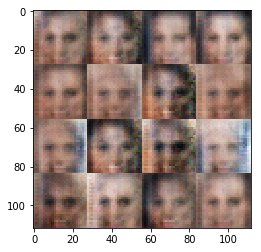

Epoch 1/1... Discriminator Loss: 0.3231... Generator Loss: 1.5442
Epoch 1/1... Discriminator Loss: 0.0472... Generator Loss: 5.2667
Epoch 1/1... Discriminator Loss: 0.8182... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 0.0730... Generator Loss: 3.4971
Epoch 1/1... Discriminator Loss: 1.8134... Generator Loss: 0.2110


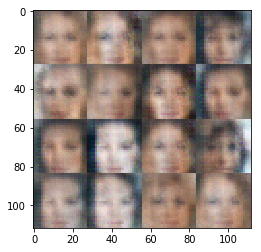

Epoch 1/1... Discriminator Loss: 0.4295... Generator Loss: 1.5039
Epoch 1/1... Discriminator Loss: 0.1379... Generator Loss: 2.8160
Epoch 1/1... Discriminator Loss: 0.0125... Generator Loss: 5.9337
Epoch 1/1... Discriminator Loss: 0.0277... Generator Loss: 7.1060
Epoch 1/1... Discriminator Loss: 0.1234... Generator Loss: 5.5327


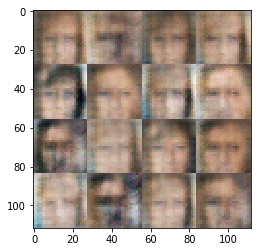

Epoch 1/1... Discriminator Loss: 0.1946... Generator Loss: 9.5794
Epoch 1/1... Discriminator Loss: 0.3882... Generator Loss: 1.4432
Epoch 1/1... Discriminator Loss: 0.0322... Generator Loss: 4.3464
Epoch 1/1... Discriminator Loss: 0.4744... Generator Loss: 1.7595
Epoch 1/1... Discriminator Loss: 0.3919... Generator Loss: 5.4461


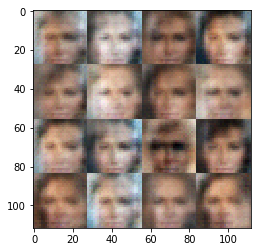

Epoch 1/1... Discriminator Loss: 0.7335... Generator Loss: 0.9342
Epoch 1/1... Discriminator Loss: 0.5396... Generator Loss: 1.3037
Epoch 1/1... Discriminator Loss: 0.0458... Generator Loss: 8.3826
Epoch 1/1... Discriminator Loss: 0.0904... Generator Loss: 8.1889
Epoch 1/1... Discriminator Loss: 0.1225... Generator Loss: 9.7468


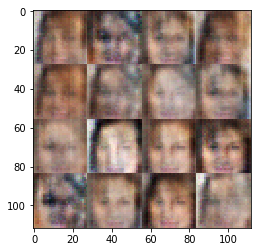

Epoch 1/1... Discriminator Loss: 0.1681... Generator Loss: 2.0877
Epoch 1/1... Discriminator Loss: 0.0302... Generator Loss: 4.6247
Epoch 1/1... Discriminator Loss: 0.0171... Generator Loss: 7.4492
Epoch 1/1... Discriminator Loss: 0.0348... Generator Loss: 4.5747
Epoch 1/1... Discriminator Loss: 0.3024... Generator Loss: 1.4838


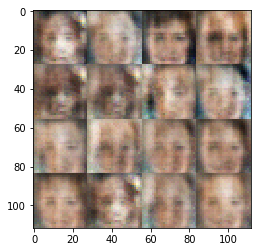

Epoch 1/1... Discriminator Loss: 0.0208... Generator Loss: 9.4209
Epoch 1/1... Discriminator Loss: 0.1856... Generator Loss: 3.0399
Epoch 1/1... Discriminator Loss: 0.0087... Generator Loss: 11.5055
Epoch 1/1... Discriminator Loss: 0.0075... Generator Loss: 8.4828
Epoch 1/1... Discriminator Loss: 0.0088... Generator Loss: 8.6833


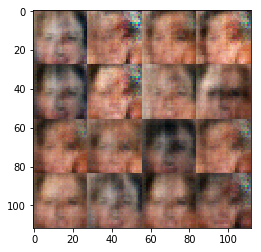

Epoch 1/1... Discriminator Loss: 0.0251... Generator Loss: 9.6478
Epoch 1/1... Discriminator Loss: 0.0674... Generator Loss: 3.0115
Epoch 1/1... Discriminator Loss: 0.1885... Generator Loss: 2.8320
Epoch 1/1... Discriminator Loss: 0.1293... Generator Loss: 3.3787
Epoch 1/1... Discriminator Loss: 0.1265... Generator Loss: 3.0970


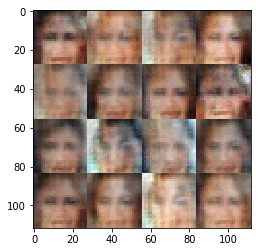

Epoch 1/1... Discriminator Loss: 0.8487... Generator Loss: 4.4515
Epoch 1/1... Discriminator Loss: 0.0480... Generator Loss: 4.0033
Epoch 1/1... Discriminator Loss: 0.2589... Generator Loss: 2.2680
Epoch 1/1... Discriminator Loss: 0.1463... Generator Loss: 2.6292
Epoch 1/1... Discriminator Loss: 0.0352... Generator Loss: 5.1187


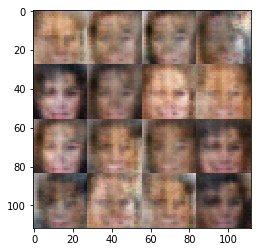

Epoch 1/1... Discriminator Loss: 0.1968... Generator Loss: 2.1698
Epoch 1/1... Discriminator Loss: 0.9722... Generator Loss: 2.5209
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 8.6663
Epoch 1/1... Discriminator Loss: 0.0246... Generator Loss: 9.9269
Epoch 1/1... Discriminator Loss: 0.6538... Generator Loss: 1.5363


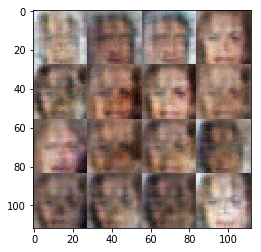

Epoch 1/1... Discriminator Loss: 1.7486... Generator Loss: 0.5334
Epoch 1/1... Discriminator Loss: 0.3005... Generator Loss: 1.7710
Epoch 1/1... Discriminator Loss: 0.4601... Generator Loss: 2.0711
Epoch 1/1... Discriminator Loss: 0.6609... Generator Loss: 2.1367
Epoch 1/1... Discriminator Loss: 0.5695... Generator Loss: 1.5369


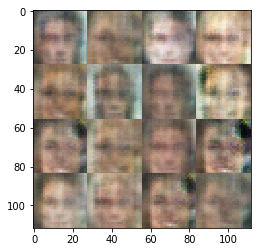

Epoch 1/1... Discriminator Loss: 0.2726... Generator Loss: 1.7054
Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 0.2607... Generator Loss: 2.4704
Epoch 1/1... Discriminator Loss: 0.8494... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 2.7974... Generator Loss: 6.1941


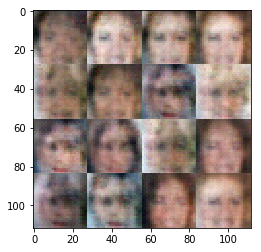

Epoch 1/1... Discriminator Loss: 1.9136... Generator Loss: 0.2826
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 0.4729
Epoch 1/1... Discriminator Loss: 0.2081... Generator Loss: 3.1384
Epoch 1/1... Discriminator Loss: 0.0662... Generator Loss: 4.8857
Epoch 1/1... Discriminator Loss: 0.1638... Generator Loss: 3.1200


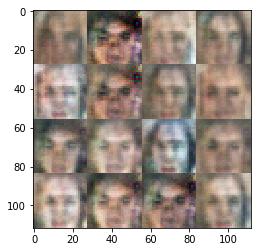

Epoch 1/1... Discriminator Loss: 0.0187... Generator Loss: 9.9765
Epoch 1/1... Discriminator Loss: 0.4139... Generator Loss: 1.3712
Epoch 1/1... Discriminator Loss: 0.2450... Generator Loss: 2.2957
Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 5.9734
Epoch 1/1... Discriminator Loss: 0.0343... Generator Loss: 7.4457


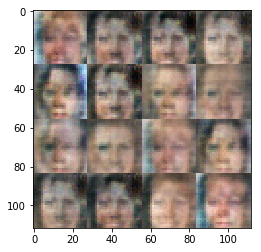

Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 0.5469
Epoch 1/1... Discriminator Loss: 0.0968... Generator Loss: 3.5653
Epoch 1/1... Discriminator Loss: 0.1614... Generator Loss: 3.3105
Epoch 1/1... Discriminator Loss: 0.1241... Generator Loss: 3.0270
Epoch 1/1... Discriminator Loss: 1.6926... Generator Loss: 0.3355


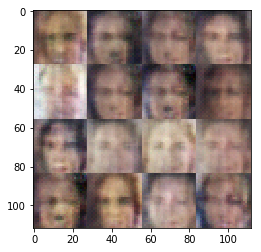

Epoch 1/1... Discriminator Loss: 0.1383... Generator Loss: 3.6321
Epoch 1/1... Discriminator Loss: 0.1333... Generator Loss: 3.9602
Epoch 1/1... Discriminator Loss: 0.0532... Generator Loss: 4.6716
Epoch 1/1... Discriminator Loss: 0.3068... Generator Loss: 1.7948
Epoch 1/1... Discriminator Loss: 1.9157... Generator Loss: 6.7477


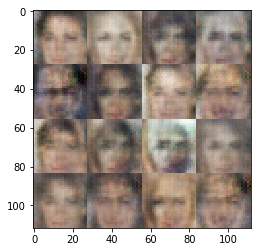

Epoch 1/1... Discriminator Loss: 0.8418... Generator Loss: 6.2192
Epoch 1/1... Discriminator Loss: 2.5182... Generator Loss: 0.1140
Epoch 1/1... Discriminator Loss: 0.1187... Generator Loss: 3.2758
Epoch 1/1... Discriminator Loss: 0.1663... Generator Loss: 7.3235
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.4189


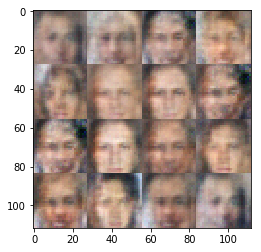

Epoch 1/1... Discriminator Loss: 0.6961... Generator Loss: 7.0874
Epoch 1/1... Discriminator Loss: 0.0297... Generator Loss: 5.8089
Epoch 1/1... Discriminator Loss: 0.1213... Generator Loss: 5.0186
Epoch 1/1... Discriminator Loss: 0.0140... Generator Loss: 6.4971
Epoch 1/1... Discriminator Loss: 0.8184... Generator Loss: 5.9352


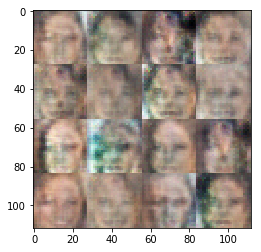

Epoch 1/1... Discriminator Loss: 0.0812... Generator Loss: 3.5814
Epoch 1/1... Discriminator Loss: 0.0132... Generator Loss: 5.4865
Epoch 1/1... Discriminator Loss: 0.0552... Generator Loss: 7.9040
Epoch 1/1... Discriminator Loss: 0.1245... Generator Loss: 4.2011
Epoch 1/1... Discriminator Loss: 0.4928... Generator Loss: 1.7839


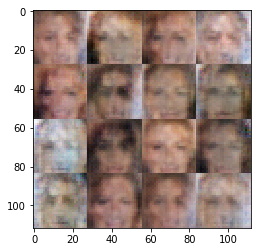

Epoch 1/1... Discriminator Loss: 0.0325... Generator Loss: 6.5952
Epoch 1/1... Discriminator Loss: 0.1150... Generator Loss: 5.7526
Epoch 1/1... Discriminator Loss: 0.0270... Generator Loss: 11.2123
Epoch 1/1... Discriminator Loss: 0.0367... Generator Loss: 4.3721
Epoch 1/1... Discriminator Loss: 0.0823... Generator Loss: 5.5065


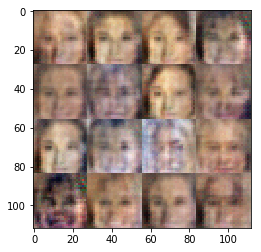

Epoch 1/1... Discriminator Loss: 0.0425... Generator Loss: 9.7814
Epoch 1/1... Discriminator Loss: 0.0630... Generator Loss: 3.7995
Epoch 1/1... Discriminator Loss: 0.6652... Generator Loss: 7.7975
Epoch 1/1... Discriminator Loss: 0.8194... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 0.4475... Generator Loss: 1.8381


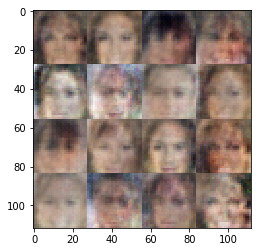

Epoch 1/1... Discriminator Loss: 0.4100... Generator Loss: 2.6626
Epoch 1/1... Discriminator Loss: 0.0591... Generator Loss: 4.4539
Epoch 1/1... Discriminator Loss: 0.0268... Generator Loss: 7.2902
Epoch 1/1... Discriminator Loss: 0.0515... Generator Loss: 6.1191
Epoch 1/1... Discriminator Loss: 0.0541... Generator Loss: 7.9318


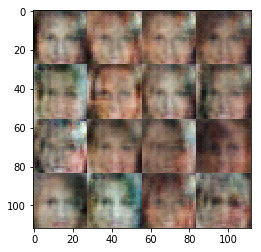

Epoch 1/1... Discriminator Loss: 0.2202... Generator Loss: 8.2386
Epoch 1/1... Discriminator Loss: 0.0850... Generator Loss: 6.7809
Epoch 1/1... Discriminator Loss: 0.1024... Generator Loss: 4.8551
Epoch 1/1... Discriminator Loss: 0.1038... Generator Loss: 3.0232
Epoch 1/1... Discriminator Loss: 0.0236... Generator Loss: 5.3538


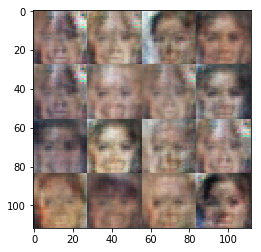

Epoch 1/1... Discriminator Loss: 0.0051... Generator Loss: 12.4061
Epoch 1/1... Discriminator Loss: 0.0083... Generator Loss: 5.5896
Epoch 1/1... Discriminator Loss: 0.3609... Generator Loss: 2.0812
Epoch 1/1... Discriminator Loss: 0.0067... Generator Loss: 7.4016
Epoch 1/1... Discriminator Loss: 0.0634... Generator Loss: 4.8728


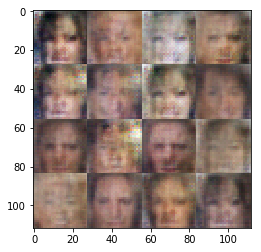

Epoch 1/1... Discriminator Loss: 0.0254... Generator Loss: 7.3588
Epoch 1/1... Discriminator Loss: 0.3041... Generator Loss: 1.7503
Epoch 1/1... Discriminator Loss: 0.0250... Generator Loss: 5.3670
Epoch 1/1... Discriminator Loss: 0.3505... Generator Loss: 2.1609
Epoch 1/1... Discriminator Loss: 0.0811... Generator Loss: 3.8471


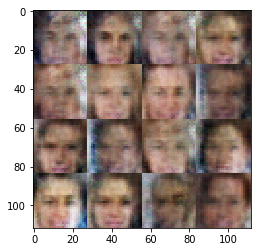

Epoch 1/1... Discriminator Loss: 0.0347... Generator Loss: 5.6660
Epoch 1/1... Discriminator Loss: 1.6385... Generator Loss: 0.3545
Epoch 1/1... Discriminator Loss: 0.7552... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 0.3006... Generator Loss: 6.2914
Epoch 1/1... Discriminator Loss: 0.7491... Generator Loss: 5.6616


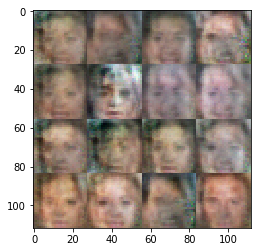

Epoch 1/1... Discriminator Loss: 0.0105... Generator Loss: 5.7365
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.5857
Epoch 1/1... Discriminator Loss: 0.4547... Generator Loss: 4.4952
Epoch 1/1... Discriminator Loss: 0.2765... Generator Loss: 2.0818
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 2.8458


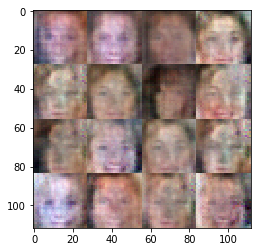

Epoch 1/1... Discriminator Loss: 0.2045... Generator Loss: 2.3653
Epoch 1/1... Discriminator Loss: 0.5549... Generator Loss: 2.0140
Epoch 1/1... Discriminator Loss: 0.0495... Generator Loss: 10.0547
Epoch 1/1... Discriminator Loss: 0.0497... Generator Loss: 3.7044
Epoch 1/1... Discriminator Loss: 0.0721... Generator Loss: 5.5980


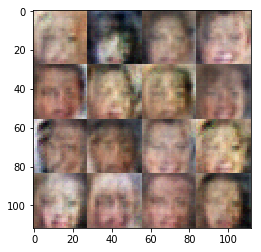

Epoch 1/1... Discriminator Loss: 2.1265... Generator Loss: 0.2286
Epoch 1/1... Discriminator Loss: 0.7948... Generator Loss: 1.2651
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 0.1785... Generator Loss: 2.6354
Epoch 1/1... Discriminator Loss: 0.0875... Generator Loss: 3.4551


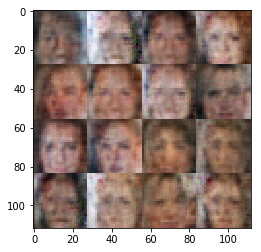

Epoch 1/1... Discriminator Loss: 0.0626... Generator Loss: 7.6666
Epoch 1/1... Discriminator Loss: 0.7225... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 0.0588... Generator Loss: 7.0414
Epoch 1/1... Discriminator Loss: 0.0537... Generator Loss: 7.5711
Epoch 1/1... Discriminator Loss: 0.5821... Generator Loss: 1.2605


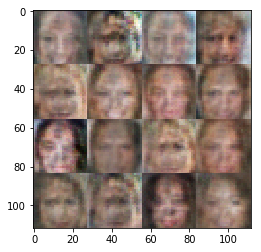

Epoch 1/1... Discriminator Loss: 0.9322... Generator Loss: 3.6070
Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 0.1067... Generator Loss: 4.5612
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 0.3227... Generator Loss: 6.5885


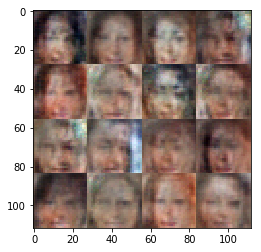

Epoch 1/1... Discriminator Loss: 2.5153... Generator Loss: 0.1299
Epoch 1/1... Discriminator Loss: 0.1884... Generator Loss: 3.7244
Epoch 1/1... Discriminator Loss: 0.2895... Generator Loss: 2.5746
Epoch 1/1... Discriminator Loss: 0.1385... Generator Loss: 2.6229
Epoch 1/1... Discriminator Loss: 0.1410... Generator Loss: 5.6297


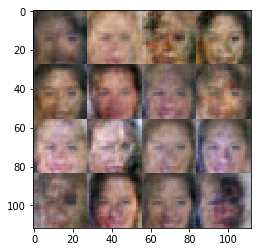

Epoch 1/1... Discriminator Loss: 0.0438... Generator Loss: 7.5205
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 4.0905
Epoch 1/1... Discriminator Loss: 0.5940... Generator Loss: 1.0559
Epoch 1/1... Discriminator Loss: 0.2154... Generator Loss: 3.7452
Epoch 1/1... Discriminator Loss: 0.2153... Generator Loss: 3.2435


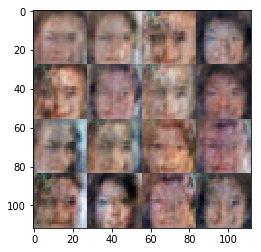

Epoch 1/1... Discriminator Loss: 0.3175... Generator Loss: 2.0697
Epoch 1/1... Discriminator Loss: 0.5814... Generator Loss: 7.1208
Epoch 1/1... Discriminator Loss: 0.1534... Generator Loss: 3.9550
Epoch 1/1... Discriminator Loss: 0.2510... Generator Loss: 3.0784
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.4335


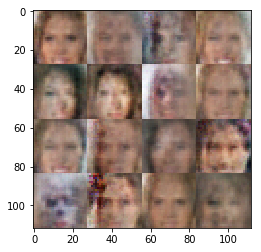

Epoch 1/1... Discriminator Loss: 0.2223... Generator Loss: 2.3273
Epoch 1/1... Discriminator Loss: 0.3198... Generator Loss: 1.9573
Epoch 1/1... Discriminator Loss: 0.3201... Generator Loss: 1.7847
Epoch 1/1... Discriminator Loss: 0.0696... Generator Loss: 3.9500
Epoch 1/1... Discriminator Loss: 0.1672... Generator Loss: 3.0430


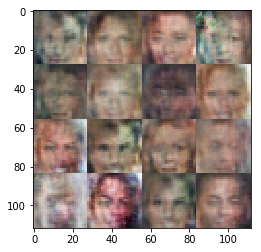

Epoch 1/1... Discriminator Loss: 0.1818... Generator Loss: 4.7308
Epoch 1/1... Discriminator Loss: 0.0256... Generator Loss: 8.7031
Epoch 1/1... Discriminator Loss: 0.1592... Generator Loss: 4.0299
Epoch 1/1... Discriminator Loss: 0.2236... Generator Loss: 2.1108
Epoch 1/1... Discriminator Loss: 0.6512... Generator Loss: 6.1323


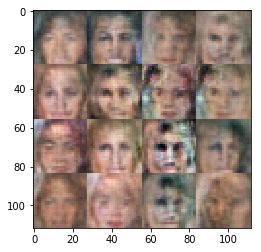

Epoch 1/1... Discriminator Loss: 0.5202... Generator Loss: 1.6104
Epoch 1/1... Discriminator Loss: 0.8962... Generator Loss: 1.7300
Epoch 1/1... Discriminator Loss: 0.4250... Generator Loss: 1.8552
Epoch 1/1... Discriminator Loss: 0.3161... Generator Loss: 3.0026
Epoch 1/1... Discriminator Loss: 0.1862... Generator Loss: 2.2661


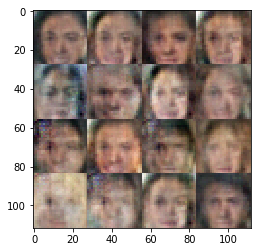

Epoch 1/1... Discriminator Loss: 0.8608... Generator Loss: 6.7248
Epoch 1/1... Discriminator Loss: 0.1509... Generator Loss: 4.0679
Epoch 1/1... Discriminator Loss: 0.1347... Generator Loss: 4.6790
Epoch 1/1... Discriminator Loss: 0.7110... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 0.2781... Generator Loss: 1.5984


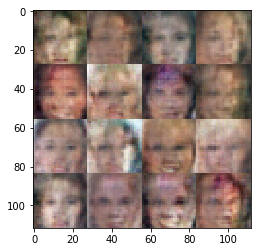

Epoch 1/1... Discriminator Loss: 2.4404... Generator Loss: 5.7998


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.